In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x:'%.3f' % x)
from pandas.tseries.offsets import *
from datetime import datetime, timedelta

C:\Users\YH817GQ\Anaconda3_new\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [43]:
def plot_series(time,series,format='-'):
    plt.figure(figsize=(0,6)).set_figwidth(15)
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time,series_num,format)
    else:
        plt.plot(time,series,format)
    
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid(True)
    plt.show

In [44]:
def train_test_split(data):
    size = int(len(data)*0.8)
    x_train = data.drop(columns=['close']).iloc[:size]
    x_test = data.drop(columns=['close']).iloc[size:]
    y_train = data['close'].iloc[:size]
    y_test = data['close'].iloc[size:]
    return x_train,x_test,y_train,y_test



def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols,names = list(),list()
    for i in range(n_in,0,-1):
        cols.append(df_temp.shift(i))
        names+=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0,n_out):
        cols.append(df_temp.shift(-1))
        if i==0:
            names+=[('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)' % (j+1,i)) for j in range(n_vars)]
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def reshape_data(train,test):
    reframed_train = series_to_supervised(train,1,1)
    reframed_test = series_to_supervised(test,1,1)
    
    train = reframed_train.values
    test = reframed_test.values
    
    train_X,y_train = train[:,:-1],train[:,-1]
    test_X,y_test = test[:,:-1], test[:,-1]
    
    x_train = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
    return x_train,x_test,y_train,y_test




In [47]:
df = pd.read_excel('bharat_dynamics.xlsx')

df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.dayofweek+1
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

df = pd.get_dummies(df,columns=['weekday','month','quarter'])
# df.drop(columns=['Open', 'High', 'Low', 'Adj Close'],axis=1,inplace=True)
df = df[~df.isna()]
df = df.sort_values('date')
df.head()

,date,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2018-03-23,389.800,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2018-03-26,396.950,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2018-03-27,405.550,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2018-03-28,396.650,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2018-04-02,392.250,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


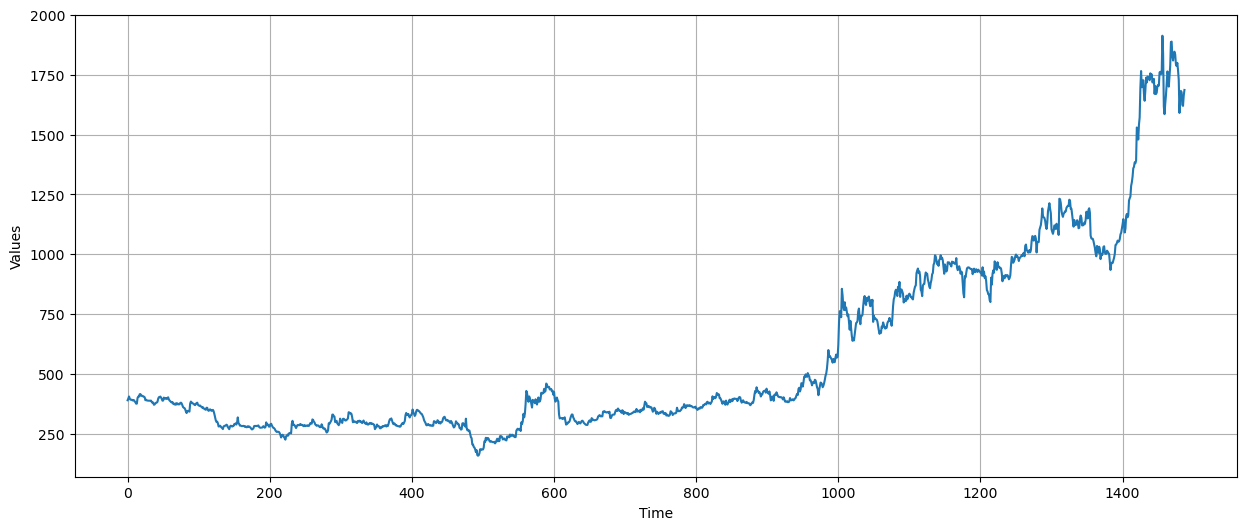

In [48]:
time = np.arange(len(df['close']))
series = df['close']
plot_series(time,series)

In [49]:
df.head()

,date,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2018-03-23,389.800,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2018-03-26,396.950,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2018-03-27,405.550,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2018-03-28,396.650,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2018-04-02,392.250,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [50]:
df = df.set_index('date')
df.head(10)

,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-23,389.800,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-03-26,396.950,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-03-27,405.550,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-03-28,396.650,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-04-02,392.250,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2018-04-03,392.250,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2018-04-04,392.100,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2018-04-05,388.900,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2018-04-06,390.750,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [51]:
df.columns

Index(['close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4'],
      dtype='object')

In [54]:
df1 = series_to_supervised(df[['close']],30,30).merge(df,how='left',on='date')
df1.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11),var1(t+12),var1(t+13),var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23),var1(t+24),var1(t+25),var1(t+26),var1(t+27),var1(t+28),var1(t+29),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-09,389.800,396.950,405.550,396.650,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,387.850,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2018-05-10,396.950,405.550,396.650,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.100,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2018-05-11,405.550,396.650,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,388.100,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2018-05-14,396.650,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,388.100,388.050,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,388.050,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2018-05-15,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,388.100,388.050,388.050,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,382.150,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [55]:
df1.columns

Index(['var1(t-30)', 'var1(t-29)', 'var1(t-28)', 'var1(t-27)', 'var1(t-26)',
       'var1(t-25)', 'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)',
       'var1(t-20)', 'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)',
       'var1(t-15)', 'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)',
       'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)',
       'var1(t)', 'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)',
       'var1(t+5)', 'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)',
       'var1(t+10)', 'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)',
       'var1(t+15)', 'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)',
       'var1(t+20)', 'var1(t+21)', 'var1(t+22)', 'var1(t+23)', 'var1(t+24)',
       'var1(t+25)', 'var1(t+26)', 'var1(t+27)', 'var1(t+28)', 'var1(t+29)',
       'close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_

In [56]:
len(df1.columns)

84

In [57]:
df1 = df1[['var1(t-30)', 'var1(t-29)', 'var1(t-28)', 'var1(t-27)', 'var1(t-26)',
       'var1(t-25)', 'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)',
       'var1(t-20)', 'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)',
       'var1(t-15)', 'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)',
       'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)',
       'close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4','var1(t)', 'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)',
       'var1(t+5)', 'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)',
       'var1(t+10)', 'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)',
       'var1(t+15)', 'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)',
       'var1(t+20)', 'var1(t+21)', 'var1(t+22)', 'var1(t+23)', 'var1(t+24)',
       'var1(t+25)', 'var1(t+26)', 'var1(t+27)', 'var1(t+28)', 'var1(t+29)']]
df1.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11),var1(t+12),var1(t+13),var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23),var1(t+24),var1(t+25),var1(t+26),var1(t+27),var1(t+28),var1(t+29)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-09,389.800,396.950,405.550,396.650,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100,388.100
2018-05-10,396.950,405.550,396.650,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,388.100,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050
2018-05-11,405.550,396.650,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,388.100,388.050,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050,388.050
2018-05-14,396.650,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,388.100,388.050,388.050,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150,382.150
2018-05-15,392.250,392.250,392.100,388.900,390.750,389.950,384.900,381.200,375.600,375.700,399.550,405.150,404.700,415.000,415.600,408.100,408.600,408.250,405.150,405.000,402.350,390.100,392.300,388.850,388.250,388.100,387.850,388.100,388.050,388.050,382.150,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000,379.000


In [58]:
df_X,df_Y = df1.values[:,:-30],df1.values[:,-30:]

In [59]:
df_X


array([[3.89800e+02, 3.96950e+02, 4.05550e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.96950e+02, 4.05550e+02, 3.96650e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.05550e+02, 3.96650e+02, 3.92250e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.75260e+03, 1.75470e+03, 1.91265e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.75470e+03, 1.91265e+03, 1.83855e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.91265e+03, 1.83855e+03, 1.61605e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [60]:
df_Y

array([[ 388.1 ,  388.1 ,  388.1 , ...,  388.1 ,  388.1 ,  388.1 ],
       [ 388.05,  388.05,  388.05, ...,  388.05,  388.05,  388.05],
       [ 388.05,  388.05,  388.05, ...,  388.05,  388.05,  388.05],
       ...,
       [1619.55, 1619.55, 1619.55, ..., 1619.55, 1619.55, 1619.55],
       [1661.9 , 1661.9 , 1661.9 , ..., 1661.9 , 1661.9 , 1661.9 ],
       [1686.05, 1686.05, 1686.05, ..., 1686.05, 1686.05, 1686.05]])

In [61]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])
Y = df_Y

In [62]:
X.shape,Y.shape

((1457, 1, 54), (1457, 30))

In [63]:
X

array([[[3.89800e+02, 3.96950e+02, 4.05550e+02, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[3.96950e+02, 4.05550e+02, 3.96650e+02, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[4.05550e+02, 3.96650e+02, 3.92250e+02, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00]],

       ...,

       [[1.75260e+03, 1.75470e+03, 1.91265e+03, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[1.75470e+03, 1.91265e+03, 1.83855e+03, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[1.91265e+03, 1.83855e+03, 1.61605e+03, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]])

In [64]:
Y

array([[ 388.1 ,  388.1 ,  388.1 , ...,  388.1 ,  388.1 ,  388.1 ],
       [ 388.05,  388.05,  388.05, ...,  388.05,  388.05,  388.05],
       [ 388.05,  388.05,  388.05, ...,  388.05,  388.05,  388.05],
       ...,
       [1619.55, 1619.55, 1619.55, ..., 1619.55, 1619.55, 1619.55],
       [1661.9 , 1661.9 , 1661.9 , ..., 1661.9 , 1661.9 , 1661.9 ],
       [1686.05, 1686.05, 1686.05, ..., 1686.05, 1686.05, 1686.05]])

In [65]:
size = int(len(X)*0.8)
x_train = X[:size]
y_train = Y[:size]

x_test = X[size:]
y_test = Y[size:]

In [66]:
x_train.shape,y_train.shape

((1165, 1, 54), (1165, 30))

In [67]:
x_test.shape,y_test.shape

((292, 1, 54), (292, 30))

In [68]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(30))
model.compile(loss='mae',optimizer='adam')
history = model.fit(x_train,y_train,epochs=30,batch_size=50,verbose=1,shuffle=False)

Epoch 1/30
24/24 [==============================] - 3s 6ms/step - loss: 246.8438
Epoch 2/30
24/24 [==============================] - 0s 6ms/step - loss: 60.9834
Epoch 3/30
24/24 [==============================] - 0s 6ms/step - loss: 43.8677
Epoch 4/30
24/24 [==============================] - 0s 6ms/step - loss: 39.8248
Epoch 5/30
24/24 [==============================] - 0s 6ms/step - loss: 36.7204
Epoch 6/30
24/24 [==============================] - 0s 6ms/step - loss: 35.2354
Epoch 7/30
24/24 [==============================] - 0s 6ms/step - loss: 34.6020
Epoch 8/30
24/24 [==============================] - 0s 6ms/step - loss: 33.5813
Epoch 9/30
24/24 [==============================] - 0s 6ms/step - loss: 33.2019
Epoch 10/30
24/24 [==============================] - 0s 5ms/step - loss: 32.6973
Epoch 11/30
24/24 [==============================] - 0s 5ms/step - loss: 32.2460
Epoch 12/30
24/24 [==============================] - 0s 5ms/step - loss: 32.0482
Epoch 13/30
24/24 [=================

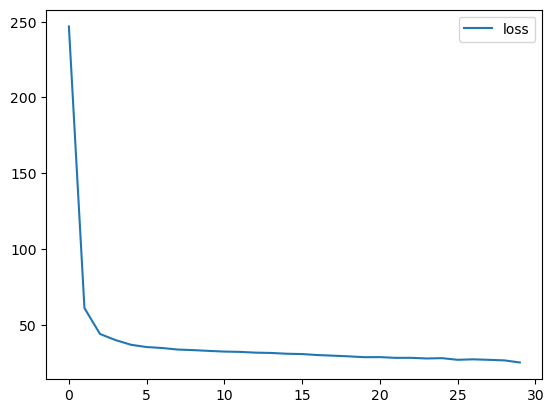

In [69]:
# Plot loss history
plt.plot(history.history['loss'],label='loss')
plt.legend()
plt.show()

In [70]:
y_test_pre = model.predict(x_test)
y_test_pre.shape,y_test.shape

10/10 [==============================] - 0s 3ms/step


((292, 30), (292, 30))

In [71]:
y_test_pre.shape

(292, 30)

In [72]:
y_test.shape

(292, 30)

In [73]:
# Make predictions
pred = pd.DataFrame()
pred['date'] = df1.reset_index()['date'][size:]
pred['predicted_close'] = list(pd.DataFrame(y_test_pre).iloc[:,0])
pred['actual_close'] = list(pd.DataFrame(y_test).iloc[:,0])
pred.head()

,date,predicted_close,actual_close
1165,2023-01-18,912.044,925.900
1166,2023-01-19,915.223,935.400
1167,2023-01-20,917.578,930.200
1168,2023-01-23,910.228,928.550
1169,2023-01-24,907.087,922.600


4.82099813353451

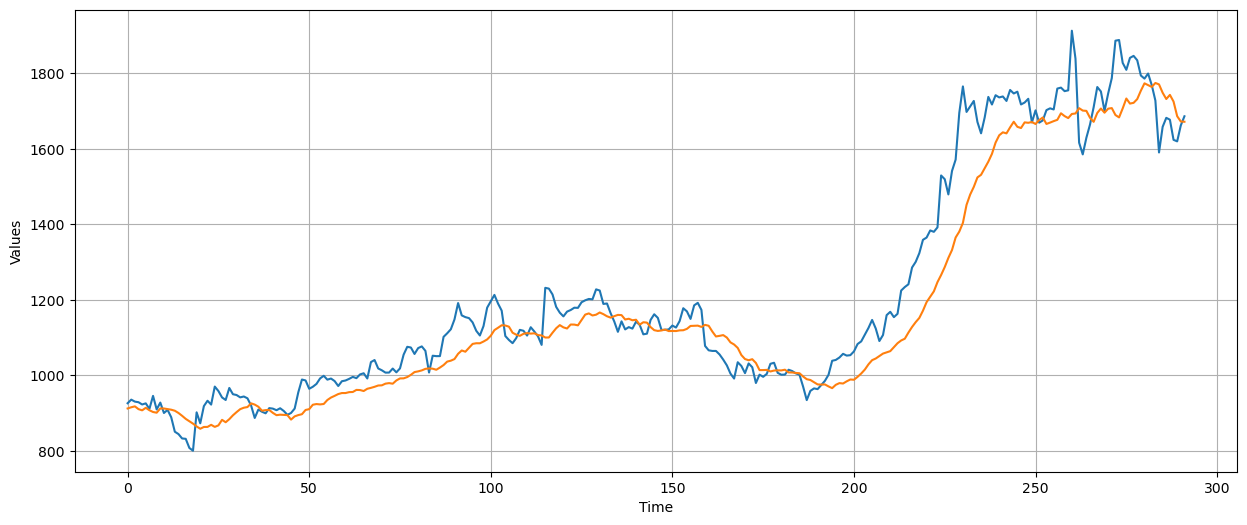

In [74]:
def measure_mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

time = np.arange(len(pred))
series1 = pred['actual_close']
series2 = pred['predicted_close']
plot_series(time,(series1,series2))
display(measure_mape(series1,series2))

In [31]:
## oot forecastingo

In [75]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(30))
model.compile(loss='mae',optimizer='adam')
history = model.fit(X,Y,epochs=30,batch_size=50,verbose=1,shuffle=False)

Epoch 1/30
30/30 [==============================] - 3s 6ms/step - loss: 185.2642
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 74.5536
Epoch 3/30
30/30 [==============================] - 0s 5ms/step - loss: 44.3356
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 43.2014
Epoch 5/30
30/30 [==============================] - 0s 5ms/step - loss: 44.6095
Epoch 6/30
30/30 [==============================] - 0s 6ms/step - loss: 46.6195
Epoch 7/30
30/30 [==============================] - 0s 5ms/step - loss: 43.0860
Epoch 8/30
30/30 [==============================] - 0s 6ms/step - loss: 45.3141
Epoch 9/30
30/30 [==============================] - 0s 5ms/step - loss: 42.2300
Epoch 10/30
30/30 [==============================] - 0s 5ms/step - loss: 43.9837
Epoch 11/30
30/30 [==============================] - 0s 5ms/step - loss: 41.1569
Epoch 12/30
30/30 [==============================] - 0s 5ms/step - loss: 41.5862
Epoch 13/30
30/30 [=================

In [88]:
df1 = series_to_supervised(df[['close']].tail(31),30,0).merge(df,how='left',on='date')
df1

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,1838.550,1616.050,1585.050,1629.200,1664.150,1709.900,1763.500,1751.650,1700.050,1746.500,1787.250,1886.250,1888.050,1827.450,1809.100,1840.750,1846.000,1834.450,1793.950,1785.800,1799.250,1768.600,1727.550,1590.150,1658.050,1681.900,1676.950,1623.650,1619.550,1661.900,1686.050,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [89]:
len(df1.columns)

54

In [91]:
df1 = df1[['var1(t-30)', 'var1(t-29)', 'var1(t-28)', 'var1(t-27)', 'var1(t-26)',
       'var1(t-25)', 'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)',
       'var1(t-20)', 'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)',
       'var1(t-15)', 'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)',
       'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)',
       'close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4']]
df1.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,1838.550,1616.050,1585.050,1629.200,1664.150,1709.900,1763.500,1751.650,1700.050,1746.500,1787.250,1886.250,1888.050,1827.450,1809.100,1840.750,1846.000,1834.450,1793.950,1785.800,1799.250,1768.600,1727.550,1590.150,1658.050,1681.900,1676.950,1623.650,1619.550,1661.900,1686.050,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [92]:
df_X = df1.values[:,:]

In [93]:
df_X.shape

(1, 54)

In [94]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])

In [95]:
X.shape

(1, 1, 54)

In [96]:
X

array([[[1.83855e+03, 1.61605e+03, 1.58505e+03, 1.62920e+03,
         1.66415e+03, 1.70990e+03, 1.76350e+03, 1.75165e+03,
         1.70005e+03, 1.74650e+03, 1.78725e+03, 1.88625e+03,
         1.88805e+03, 1.82745e+03, 1.80910e+03, 1.84075e+03,
         1.84600e+03, 1.83445e+03, 1.79395e+03, 1.78580e+03,
         1.79925e+03, 1.76860e+03, 1.72755e+03, 1.59015e+03,
         1.65805e+03, 1.68190e+03, 1.67695e+03, 1.62365e+03,
         1.61955e+03, 1.66190e+03, 1.68605e+03, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00]]])

In [138]:
d = pd.DataFrame()
d['eod_date'] = pd.bdate_range(start=pd.to_datetime('2024-03-25'),end=pd.to_datetime('2024-03-25')+pd.DateOffset(41))
d['forecast'] = model.predict(X)[0]

1/1 [==============================] - 0s 43ms/step


In [140]:
d

,eod_date,forecast
0,2024-03-25,1645.313
1,2024-03-26,1645.536
2,2024-03-27,1653.878
3,2024-03-28,1650.206
4,2024-03-29,1643.292
5,2024-04-01,1648.980
6,2024-04-02,1648.105
7,2024-04-03,1656.215
8,2024-04-04,1649.817
9,2024-04-05,1652.123


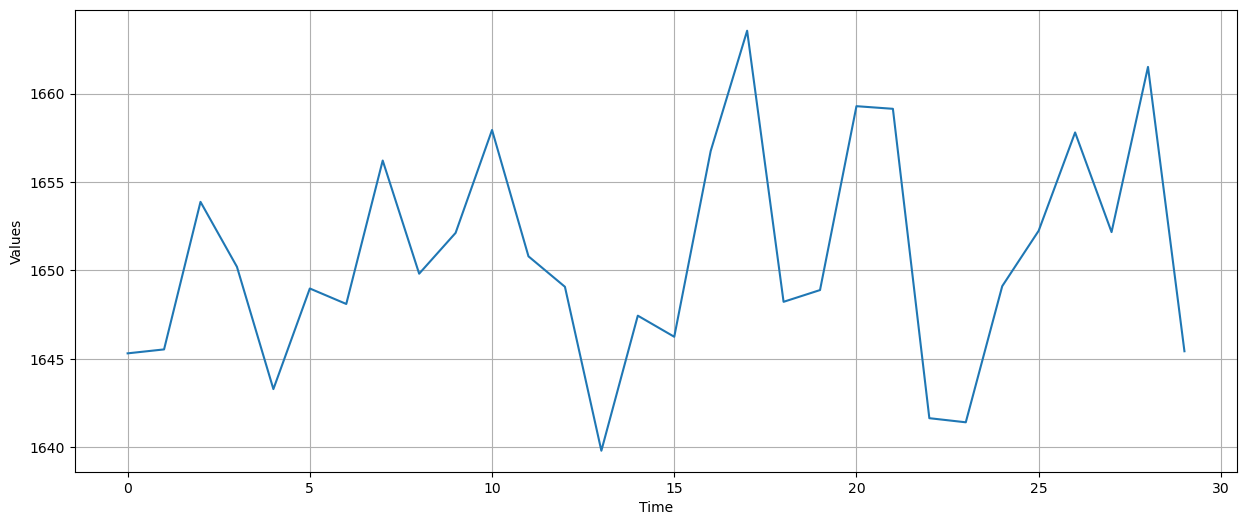

In [141]:
time = np.arange(len(d))
series1 = d['forecast']
# series2 = pred['predicted_close']
plot_series(time,(series1))
# display(measure_mape(series1,series2))